### Getting Started

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-bright")

In [3]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")
data

,Close,Volume
Date,,
2017-08-17 04:00:00,4308.83,47.181009
2017-08-17 05:00:00,4315.32,23.234916
2017-08-17 06:00:00,4324.35,7.229691
2017-08-17 07:00:00,4349.99,4.443249
2017-08-17 08:00:00,4360.69,0.972807
...,...,...
2021-10-07 05:00:00,54735.76,2251.122020
2021-10-07 06:00:00,54534.16,1783.004260
2021-10-07 07:00:00,54755.92,4163.431360


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   36168 non-null  float64
 1   Volume  36168 non-null  float64
dtypes: float64(2)
memory usage: 847.7 KB


In [5]:
data["returns"] = np.log(data.Close / data.Close.shift(1))
data

,Close,Volume,returns
Date,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4360.69,0.972807,0.002457
...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54755.92,4163.431360,0.004058


# **Strategy Optimization (Part1)**
##### **Three Strategy Parameters**

- Return Threshold: All Returns >= 90th Percentile labeled "Very High Return"
- Low and High Volume Change Threshold: All Volume Changes between 5th and 20th Percentile labeled "Moderate to High Decrease in Volume"


**Strategy Parameters = (90,5,20)**

In [6]:
data

,Close,Volume,returns
Date,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4360.69,0.972807,0.002457
...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54755.92,4163.431360,0.004058


In [13]:
def backtest (data, parameters, tc):
    #prepare features
    data = data[["Close","Volume","returns"]].copy()
    data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
    data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
    data.loc[data.vol_ch < -3, "vol_ch"] = np.nan

    #define trading positions
    return_thresh = np.percentile(data.returns.dropna(), parameters[0])
    cond1 = data.returns >= return_thresh
    volume_thresh = np.percentile(data.vol_ch.dropna(), [parameters[1], parameters[2]])
    cond2 = data.vol_ch.between(volume_thresh[0], volume_thresh[1])

    data["position"] = 1
    data.loc[cond1 & cond2, "position"] = 0

    #backteest
    data["strategy"] = data.position.shift(1) * data["returns"]
    data["trades"] = data.position.diff().fillna(0).abs()
    data.strategy = data.strategy + data.trades * tc
    data["creturns"] = data["returns"].cumsum().apply(np.exp)
    data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

    #retrun strategy multiple
    return data.cstrategy[-1]

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
backtest(data = data, parameters = (90,5,20), tc = -0.00085)

19.056162979544915

In [17]:
return_range = range(85, 98, 1)
vol_low_range = range(2, 16, 1)
vol_high_range = range(16, 35, 1)

In [18]:
list(return_range)

[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]

In [19]:
from itertools import product

In [20]:
combinations = list(product(return_range, vol_low_range, vol_high_range))
combinations

[(85, 2, 16),
 (85, 2, 17),
 (85, 2, 18),
 (85, 2, 19),
 (85, 2, 20),
 (85, 2, 21),
 (85, 2, 22),
 (85, 2, 23),
 (85, 2, 24),
 (85, 2, 25),
 (85, 2, 26),
 (85, 2, 27),
 (85, 2, 28),
 (85, 2, 29),
 (85, 2, 30),
 (85, 2, 31),
 (85, 2, 32),
 (85, 2, 33),
 (85, 2, 34),
 (85, 3, 16),
 (85, 3, 17),
 (85, 3, 18),
 (85, 3, 19),
 (85, 3, 20),
 (85, 3, 21),
 (85, 3, 22),
 (85, 3, 23),
 (85, 3, 24),
 (85, 3, 25),
 (85, 3, 26),
 (85, 3, 27),
 (85, 3, 28),
 (85, 3, 29),
 (85, 3, 30),
 (85, 3, 31),
 (85, 3, 32),
 (85, 3, 33),
 (85, 3, 34),
 (85, 4, 16),
 (85, 4, 17),
 (85, 4, 18),
 (85, 4, 19),
 (85, 4, 20),
 (85, 4, 21),
 (85, 4, 22),
 (85, 4, 23),
 (85, 4, 24),
 (85, 4, 25),
 (85, 4, 26),
 (85, 4, 27),
 (85, 4, 28),
 (85, 4, 29),
 (85, 4, 30),
 (85, 4, 31),
 (85, 4, 32),
 (85, 4, 33),
 (85, 4, 34),
 (85, 5, 16),
 (85, 5, 17),
 (85, 5, 18),
 (85, 5, 19),
 (85, 5, 20),
 (85, 5, 21),
 (85, 5, 22),
 (85, 5, 23),
 (85, 5, 24),
 (85, 5, 25),
 (85, 5, 26),
 (85, 5, 27),
 (85, 5, 28),
 (85, 5, 29),
 (85, 

In [21]:
len(combinations)

3458

In [22]:
13 * 14 * 19

3458

In [23]:
result = []
for comb in combinations:
    result.append(backtest(data = data, parameters = comb, tc = -0.00085))
result

[16.53112759650127,
 17.04218157810495,
 18.613171849788788,
 18.607121967064895,
 17.445943610373686,
 16.46440305976593,
 15.438704110820478,
 12.847696327987544,
 13.940414610392567,
 13.698052810089928,
 13.975674425775924,
 15.466121834079749,
 14.634107897927356,
 13.039149557203931,
 11.209095724355409,
 12.542487344406002,
 11.359398710306376,
 11.12917181991909,
 10.499414705494415,
 16.556303301838568,
 17.06813558149702,
 18.64151835713672,
 18.63545926088132,
 17.472512513983162,
 16.489477148485452,
 15.46221613462021,
 12.867262435328287,
 13.961644848224989,
 13.718913948522793,
 13.996958361743353,
 15.489675613078314,
 14.656394580197556,
 13.059007233892025,
 11.226166362120827,
 12.561588640656753,
 11.376698248590762,
 11.146120739389426,
 10.515404550669686,
 16.956476854738735,
 17.480680358704074,
 19.09209252797832,
 19.085886980547762,
 17.894831269766943,
 16.888035482171045,
 15.835945091712587,
 13.178270154320252,
 14.299104299250121,
 14.050506480782209,
 

In [25]:
many_results = pd.DataFrame(data = combinations, columns = ["returns", "vol_low", "vol_high"])
many_results["performance"] = result

In [26]:
many_results

,returns,vol_low,vol_high,performance
0,85,2,16,16.531128
1,85,2,17,17.042182
2,85,2,18,18.613172
3,85,2,19,18.607122
4,85,2,20,17.445944
...,...,...,...,...
3453,97,15,30,13.129257
3454,97,15,31,14.376261
3455,97,15,32,13.286913
3456,97,15,33,12.649590


In [29]:
many_results["performance"].idxmax()

2595

In [30]:
many_results.loc[2595]

returns        94.000000
vol_low        12.000000
vol_high       27.000000
performance    30.049242
Name: 2595, dtype: float64

# **Strategy Optimization (Part2)**

In [31]:
many_results

,returns,vol_low,vol_high,performance
0,85,2,16,16.531128
1,85,2,17,17.042182
2,85,2,18,18.613172
3,85,2,19,18.607122
4,85,2,20,17.445944
...,...,...,...,...
3453,97,15,30,13.129257
3454,97,15,31,14.376261
3455,97,15,32,13.286913
3456,97,15,33,12.649590


In [32]:
many_results.nlargest(20, "performance")

,returns,vol_low,vol_high,performance
2595,94,12,27,30.049242
2596,94,12,28,29.118324
2329,93,12,27,28.758840
2576,94,11,27,28.607623
2599,94,12,31,28.347644
2865,95,12,31,28.250187
2291,93,10,27,28.126993
2310,93,11,27,28.089283
2861,95,12,27,28.025133
2063,92,12,27,28.011543


In [33]:
many_results.nsmallest(20,"performance")

,returns,vol_low,vol_high,performance
265,85,15,34,8.919101
264,85,15,33,9.454071
261,85,15,30,9.635953
263,85,15,32,9.698984
531,86,15,34,10.086398
1595,90,15,34,10.357921
18,85,2,34,10.499415
37,85,3,34,10.515405
75,85,5,34,10.646851
797,87,15,34,10.731116


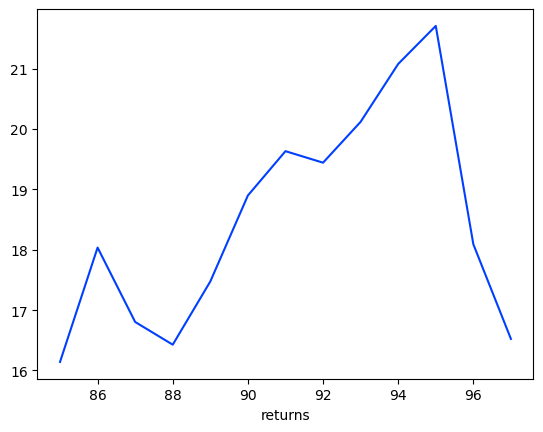

In [38]:
#return에 다른 performance의 평균 
#ex)return이 93~95일때 좋은 performance를 가져온다고 해석할 수 있다.
many_results.groupby("returns").performance.mean().plot()
plt.show()

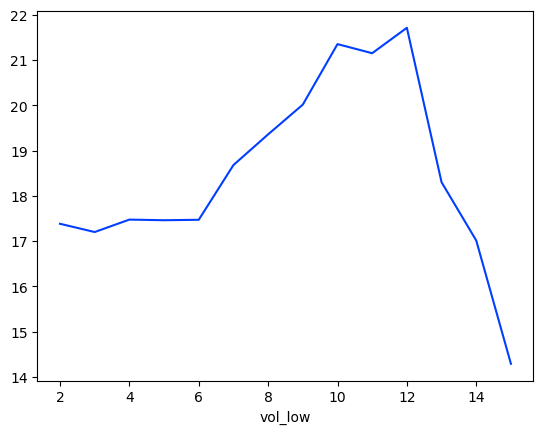

In [39]:
many_results.groupby("vol_low").performance.mean().plot()
plt.show()

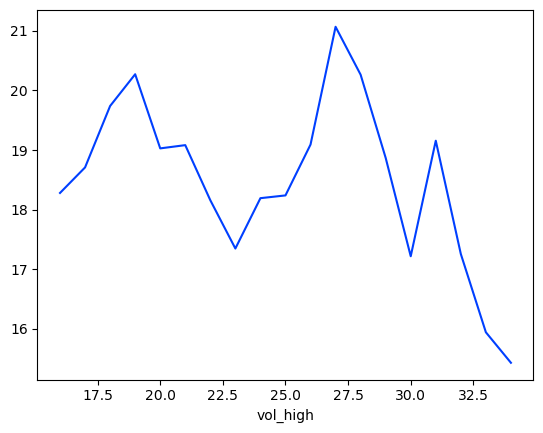

In [37]:
many_results.groupby("vol_high").performance.mean().plot()
plt.show()